In [18]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tenacity import retry, stop_after_attempt, wait_exponential, RetryError
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import f_oneway
import numpy as np
import os
import re

URL_PAGE = "https://www.gov.uk/government/statistics/oil-and-oil-products-section-3-energy-trends"
TARGET_MATCH_PHRASE = "Supply and use of crude oil, natural gas liquids and feedstocks"
LAST_LINK_FILE = 'last_link.txt'
CSV_OUTPUT_FILE = "cleaned_energy_data.csv"
DOWNLOADED_EXCEL_FILE = "downloaded_energy_data.xlsx"

In [2]:
def extract_link_from_jsonld(soup):
    script_tags = soup.find_all("script", type="application/ld+json")
    for tag in script_tags:
        try:
            data = json.loads(tag.string)
        except json.JSONDecodeError:
            continue

        items = data if isinstance(data, list) else [data]
        for item in items:
            if item.get('@type') == 'BreadcrumbList':
                continue

            distributions = item.get("distribution", [])
            if isinstance(distributions, dict):
                distributions = [distributions]
            for d in distributions:
                if TARGET_MATCH_PHRASE in d.get("name", ""):
                    return d.get("contentUrl")
    return None        

In [3]:
def load_last_link(filepath=LAST_LINK_FILE):
    if os.path.exists(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            return f.read().strip()
    return None

In [4]:
def save_last_link(link, filepath=LAST_LINK_FILE):
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(link)

In [5]:
@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def download_file_with_retry(url, filename=DOWNLOADED_EXCEL_FILE):
    response = requests.get(url)
    response.raise_for_status()
    
    with open(filename, "wb") as file:
        file.write(response.content)

    print(f"File downloaded: {filename}")
    return filename

In [6]:
def download_if_needed(new_link, last_link):
    downloaded_file_exists = os.path.exists(DOWNLOADED_EXCEL_FILE)
    if (last_link != new_link) or (not downloaded_file_exists):
        try:
            download_file_with_retry(new_link)
            save_last_link(new_link)
        except RetryError as e:
            print("Download failed after all retries:", e)
            raise
    else:
        print("Link unchanged and file exists. No download required.")

In [7]:
def is_valid_quarter_column(col_name):
    pattern = re.compile(
        r"^\s*(\d{4})\s*\n\s*(\d)(st|nd|rd|th)\s*quarter(?:\s*\[provisional\])?\s*$",
        re.IGNORECASE
    )
    return bool(pattern.match(col_name))

In [8]:
def log_and_integrity_check(df, min_rows_threshold, max_missing_threshold):
    errors = []
    
    # Check number of rows
    num_rows = df.shape[0]
    if num_rows < min_rows_threshold:
        errors.append(f"Row count {num_rows} is less than the minimum required {min_rows_threshold}.")
    
    # Check total missing values
    total_missing = df.isnull().sum().sum()
    if total_missing > max_missing_threshold:
        errors.append(f"Total missing values {total_missing} exceed the allowed threshold of {max_missing_threshold}.")
    
    # Check that all columns (other than the primary 'Category' column) match the valid quarter pattern.
    invalid_quarter_columns = [
        col for col in df.columns 
        if col != "Column1" and not is_valid_quarter_column(col)
    ]
    if invalid_quarter_columns:
        errors.append("Invalid quarter columns: " + ", ".join(invalid_quarter_columns))
    
    if errors:
        error_msg = "Integrity check failed:\n" + "\n".join(errors)
        raise Exception(error_msg)
    else:
        print("Integrity check passed.")

In [9]:
def clean_and_restructure(file_path, file_name):
    # Load the file in wide format
    df_wide = pd.read_excel(file_path, sheet_name="Quarter", skiprows=4, header=0)

    # Run integrity checks
    log_and_integrity_check(
        df_wide,
        min_rows_threshold=19,
        max_missing_threshold=0
    )

    # Rename the first column to "category"
    df_wide.rename(columns={df_wide.columns[0]: "category"}, inplace=True)
    
    # Reshape the dataset from wide to long format
    df_long = df_wide.melt(id_vars=["category"], var_name="period", value_name="value")
    
    # Extract the year from 'period'
    df_long["year"] = df_long["period"].str.extract(r"(\d{4})").astype(int)
    df_long["quarter"] = df_long["period"].str.extract(r"\n(\d)")[0]
    
    # If that fails (all values are NaN), use a general pattern looking for a digit before "quarter"
    if df_long["quarter"].isnull().all():
        df_long["quarter"] = df_long["period"].str.extract(r"(\d)[a-z]*\s*quarter", flags=re.IGNORECASE)[0]
    df_long["quarter"] = df_long["quarter"].astype(int)
    
    # Drop the 'period' column
    df_long.drop(columns=["period"], inplace=True)
    
    # Convert non-numeric values in 'value' to NaN
    df_long["value"] = pd.to_numeric(df_long["value"], errors="coerce")
    
    # Clean up category names: lowercase, replace '&' with 'and', spaces to underscores,
    # remove note references (e.g., [note_2]), and remove trailing underscores.
    df_long["category"] = (
        df_long["category"]
        .str.lower()
        .str.replace("&", "and")
        .str.replace(" ", "_")
        .str.replace(r"\[note_\d+\]", "", regex=True)
        .str.strip()
        .str.rstrip('_')
    )
    
    # Add a quarter_date column using the first day of the quarter
    quarter_start_month = {1: "01", 2: "04", 3: "07", 4: "10"}
    df_long["quarter_date"] = pd.to_datetime(
        df_long["year"].astype(str) + "-" + df_long["quarter"].map(quarter_start_month) + "-01"
    )

    # Add the filename where the data came from
    df_long["file_name"] = file_name

    # Add a processed date column
    df_long['processed_date'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Save cleaned dataset to CSV
    df_long.to_csv(CSV_OUTPUT_FILE, index=False, na_rep="")
    print(f"Cleaned data saved to {CSV_OUTPUT_FILE}")
    
    return df_long

In [ ]:
def perform_energy_eda():
    """
    Consolidated EDA for cleaned energy data.
    
    Analyses performed:
      1. Overall Summary Statistics.
      2. Supply Breakdown (including computed total supply).
      3. Demand Breakdown (including computed total demand).
      4. Time Series Trends for key energy variables.
      5. Inventory Dynamics (stock draw vs. build).
      6. Seasonal Patterns in indigenous production (ensuring Q1–Q4).
      7. Correlation Analysis.
      8. Outlier Detection via box plots.
      9. Regression Analysis on Indigenous Production over Time
      10. Time Series Decomposition for Indigenous Production
      11. ANOVA: Testing Differences Across Quarters for Indigenous Production
    """
    # Load cleaned data (ensuring "quarter_date" is parsed as datetime)
    df = pd.read_csv(CSV_OUTPUT_FILE, parse_dates=["quarter_date"])
    
    # Create a wide-format pivot table for some analyses
    df_wide = df.pivot_table(index="quarter_date", columns="category", values="value", aggfunc="sum")
    
    # -------------------------------
    # 1. Overall Summary Statistics
    # -------------------------------
    print("Overall Summary Statistics:")
    print(df_wide.describe())
    
    # -------------------------------
    # 2. Supply Breakdown
    # -------------------------------
    supply_categories = ["indigenous_production", "imports", "exports", "stock_change", "transfers"]
    df_supply = df[df["category"].isin(supply_categories)]
    supply_pivot = df_supply.pivot_table(index="quarter_date", columns="category", values="value", aggfunc="sum")
    # Compute Total Supply: indigenous_production + imports + stock_change + transfers - exports
    supply_pivot["computed_total_supply"] = (
        supply_pivot["indigenous_production"] +
        supply_pivot["imports"] +
        supply_pivot["stock_change"] +
        supply_pivot["transfers"] -
        supply_pivot["exports"]
    )
    # Plot supply components over time
    plt.figure(figsize=(12, 6))
    for col in supply_categories:
        plt.plot(supply_pivot.index, supply_pivot[col], label=col)
    plt.plot(supply_pivot.index, supply_pivot["computed_total_supply"],
             label="computed_total_supply", linewidth=2, color="black")
    plt.title("Supply Components Over Time")
    plt.xlabel("Year")
    plt.ylabel("Value (thousand tonnes)")
    plt.legend(title="Supply Components")
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # 3. Demand Breakdown
    # -------------------------------
    demand_categories = ["transformation", "energy_industry_use"]
    df_demand = df[df["category"].isin(demand_categories)]
    demand_pivot = df_demand.pivot_table(index="quarter_date", columns="category", values="value", aggfunc="sum")
    demand_pivot["computed_total_demand"] = (
        demand_pivot["transformation"] +
        demand_pivot["energy_industry_use"]
    )
    plt.figure(figsize=(12, 6))
    for col in demand_categories:
        plt.plot(demand_pivot.index, demand_pivot[col], label=col)
    plt.plot(demand_pivot.index, demand_pivot["computed_total_demand"],
             label="computed_total_demand", linewidth=2, color="black")
    plt.title("Demand Components Over Time")
    plt.xlabel("Year")
    plt.ylabel("Value (thousand tonnes)")
    plt.legend(title="Demand Components")
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # 4. Time Series Trends for Key Variables
    # -------------------------------
    ts_categories = ["indigenous_production", "imports", "exports", "stock_change"]
    df_ts = df[df["category"].isin(ts_categories)]
    ts_pivot = df_ts.pivot_table(index="quarter_date", columns="category", values="value", aggfunc="sum")
    plt.figure(figsize=(14, 7))
    for cat in ts_categories:
        plt.plot(ts_pivot.index, ts_pivot[cat], marker='o', label=cat, linewidth=1.5)
    plt.title("Quarterly Trends for Key Energy Variables")
    plt.xlabel("Year")
    plt.ylabel("Value (thousand tonnes)")
    plt.legend(title="Variables")
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # 5. Inventory Dynamics
    # -------------------------------
    df_inventory = df[df["category"] == "stock_change"]
    inv_pivot = df_inventory.pivot_table(index="quarter_date", columns="category", values="value", aggfunc="sum")
    inv_pivot["stock_draw"] = inv_pivot["stock_change"].clip(lower=0)
    inv_pivot["stock_build"] = inv_pivot["stock_change"].clip(upper=0).abs()
    plt.figure(figsize=(12, 6))
    plt.plot(inv_pivot.index, inv_pivot["stock_change"], label="stock_change", linewidth=2, color="black")
    plt.plot(inv_pivot.index, inv_pivot["stock_draw"], label="stock_draw (draw)", linestyle="--", color="green")
    plt.plot(inv_pivot.index, inv_pivot["stock_build"], label="stock_build (build)", linestyle="--", color="red")
    plt.title("Inventory Dynamics: Stock Change Over Time")
    plt.xlabel("Year")
    plt.ylabel("Value (thousand tonnes)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # 6. Seasonal Patterns in Indigenous Production
    # -------------------------------
    # Ensure quarter information is available by extracting from quarter_date.
    df["quarter_num"] = df["quarter_date"].dt.quarter
    indigenous = df[df["category"] == "indigenous_production"]
    seasonal = indigenous.groupby("quarter_num")["value"].mean().reindex([1, 2, 3, 4])
    plt.figure(figsize=(10, 6))
    plt.plot(seasonal.index, seasonal.values, marker="o", linewidth=2)
    plt.title("Seasonal Pattern: Average Indigenous Production by Quarter")
    plt.xlabel("Quarter (1-4)")
    plt.ylabel("Average Value (thousand tonnes)")
    plt.xticks([1, 2, 3, 4])
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # 7. Correlation Analysis
    # -------------------------------
    plt.figure(figsize=(10, 8))
    corr_matrix = df_wide.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", square=True)
    plt.title("Correlation Matrix of Energy Variables")
    plt.show()
    
    # -------------------------------
    # 8. Outlier Analysis (Box Plots)
    # -------------------------------
    plt.figure(figsize=(12, 8))
    df_wide.boxplot()
    plt.title("Box Plots for Energy Variables (Outlier Detection)")
    plt.xticks(rotation=90)
    plt.ylabel("Value (thousand tonnes)")
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # 9. Regression Analysis on Indigenous Production Over Time
    # -------------------------------
    # Filter indigenous production data and create a time index
    df_ind = indigenous.sort_values("quarter_date").reset_index(drop=True)
    df_ind["time_index"] = np.arange(len(df_ind))
    
    # Add a constant term for regression intercept
    X = sm.add_constant(df_ind["time_index"])
    y = df_ind["value"]
    
    model = sm.OLS(y, X).fit()
    print("\nRegression Analysis: Indigenous Production over Time")
    print(model.summary())
    
    # -------------------------------
    # 10. Time Series Decomposition for Indigenous Production
    # -------------------------------
    # Assume the data is quarterly (frequency=4)
    df_ind = df[df["category"] == "indigenous_production"]
    if df_ind.empty:
        print("No data found for indigenous production; skipping seasonal decomposition.")
    else:
        # Drop any missing values for decomposition
        df_ind_ts = df_ind.set_index("quarter_date").asfreq("QE").dropna(subset=["value"])
        if len(df_ind_ts) < 8:
            print("Insufficient observations for seasonal decomposition: only", len(df_ind_ts), "observations found.")
        else:
            decomposition = seasonal_decompose(df_ind_ts["value"], model='additive', period=4)
            fig = decomposition.plot()
            fig.set_size_inches(14, 8)
            plt.suptitle("Time Series Decomposition: Indigenous Production")
            plt.show()

    
    # -------------------------------
    # 11. ANOVA: Testing Differences Across Quarters for Indigenous Production
    # -------------------------------
    # Group indigenous production by quarter
    groups = [group["value"].values for name, group in indigenous.groupby("quarter_num")]
    f_stat, p_val = f_oneway(*groups)
    print("\nANOVA Test for Indigenous Production Across Quarters:")
    print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("Result: Significant differences exist between quarters.")
    else:
        print("Result: No significant differences detected between quarters.")



Link unchanged and file exists. No download required.
Integrity check passed.
Cleaned data saved to cleaned_energy_data.csv
Overall Summary Statistics:
category     crude_oil  crude_oil_and_ngls  energy_industry_use       exports  \
count       103.000000          103.000000           103.000000    103.000000   
mean      15690.511359        23590.612913             5.990291  12298.977864   
std        7151.539742         5659.100306            20.803839   5244.956673   
min        6874.550000        15528.870000             0.000000   6255.040000   
25%       10328.760000        19431.950000             0.000000   8357.165000   
50%       12562.130000        21992.240000             0.000000  10773.800000   
75%       19549.510000        26297.685000             0.000000  14194.530000   
max       32932.350000        39904.940000            83.810000  25486.880000   

category   feedstocks       imports  indigenous_production         ngls  \
count      103.000000    103.000000        

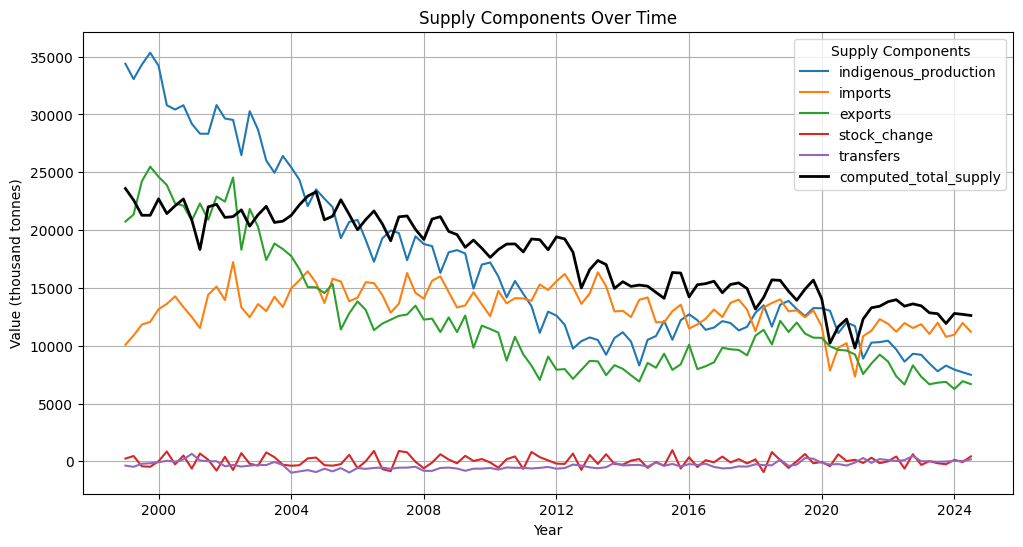

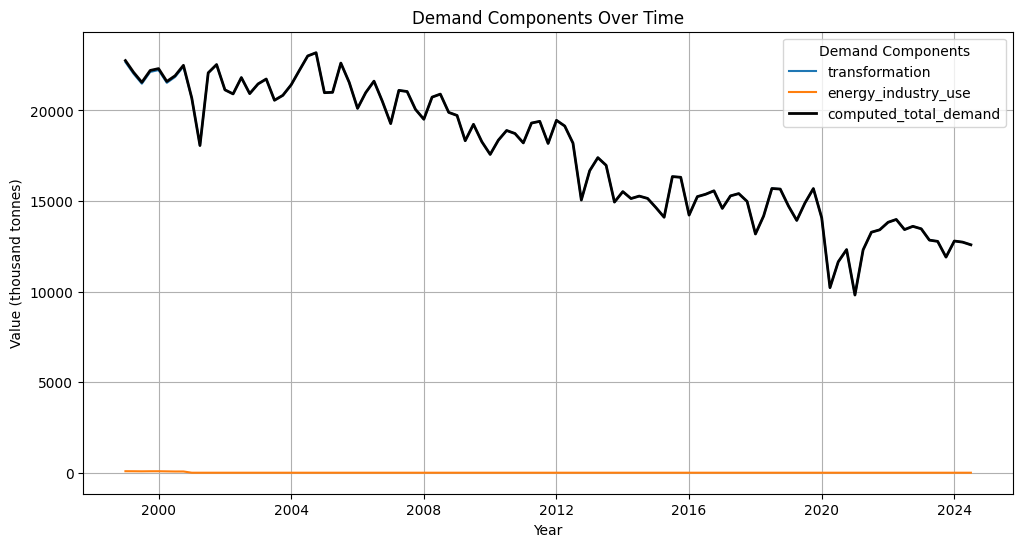

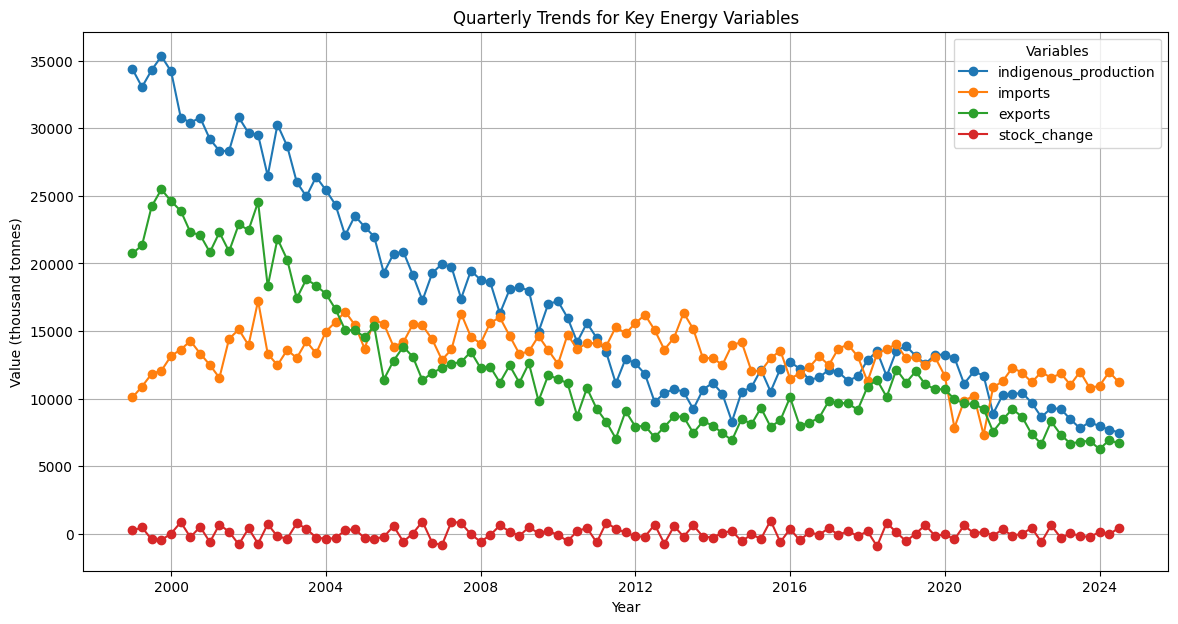

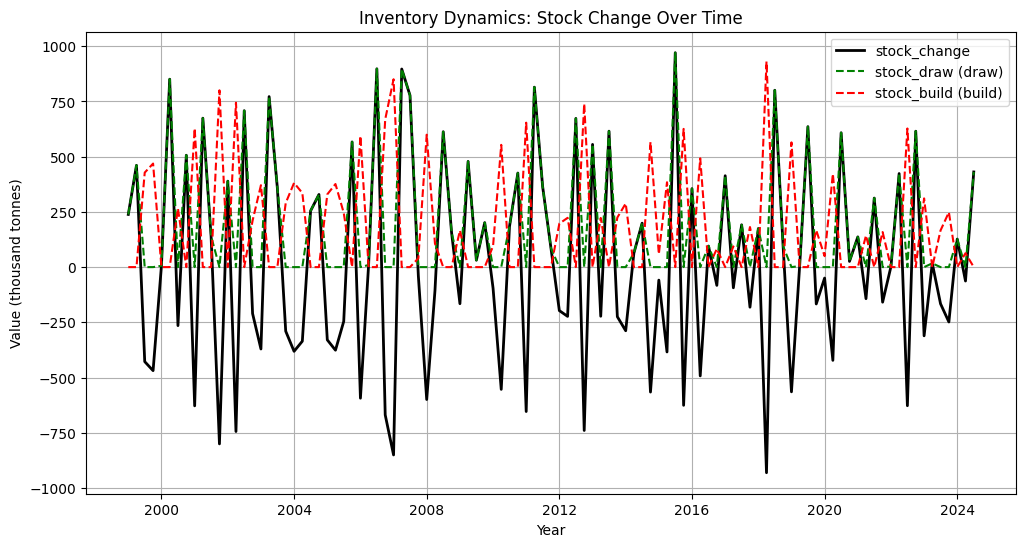

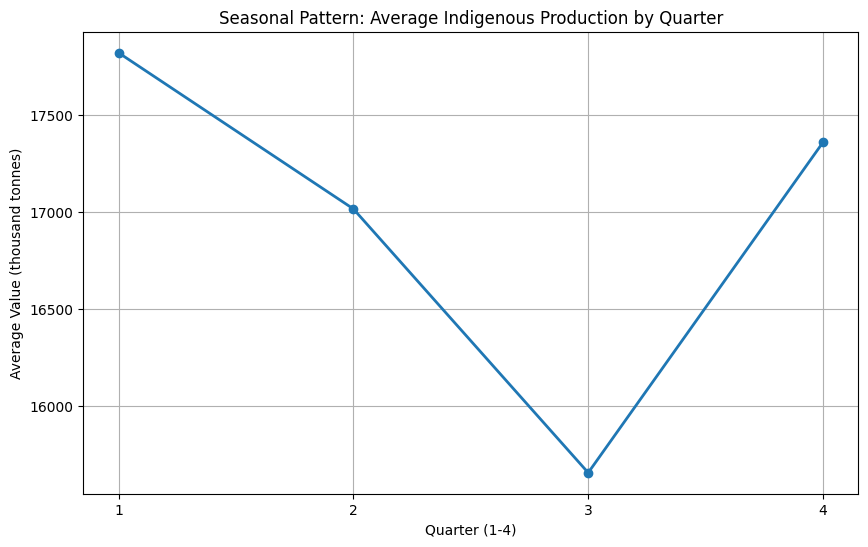

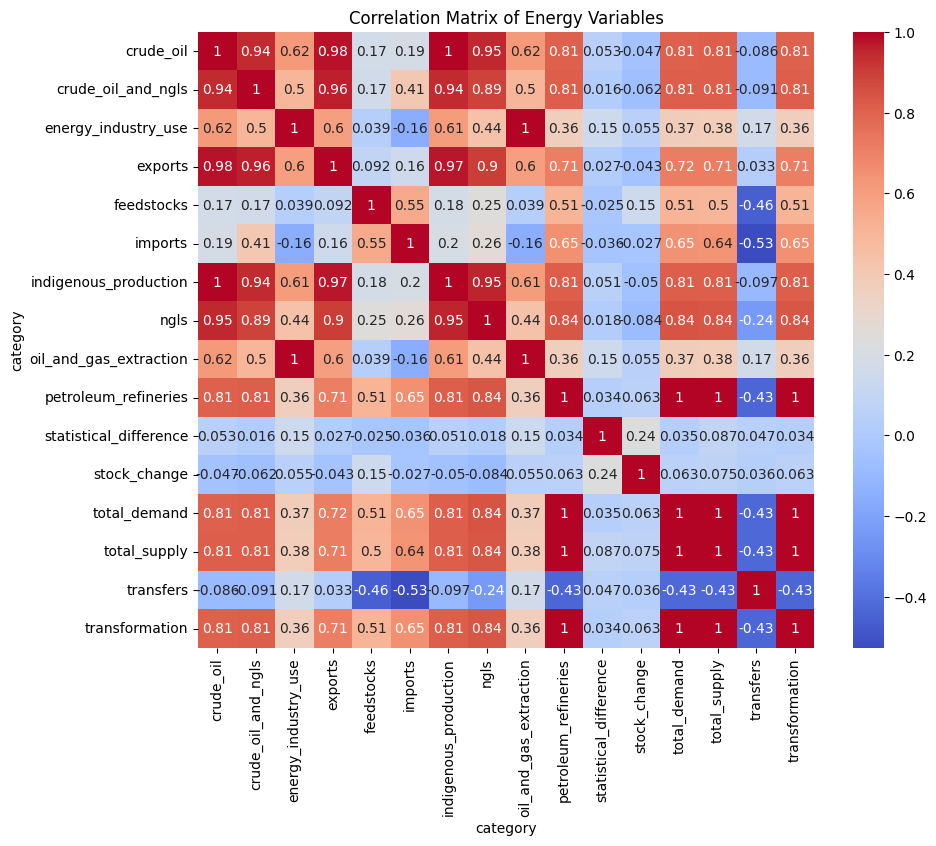

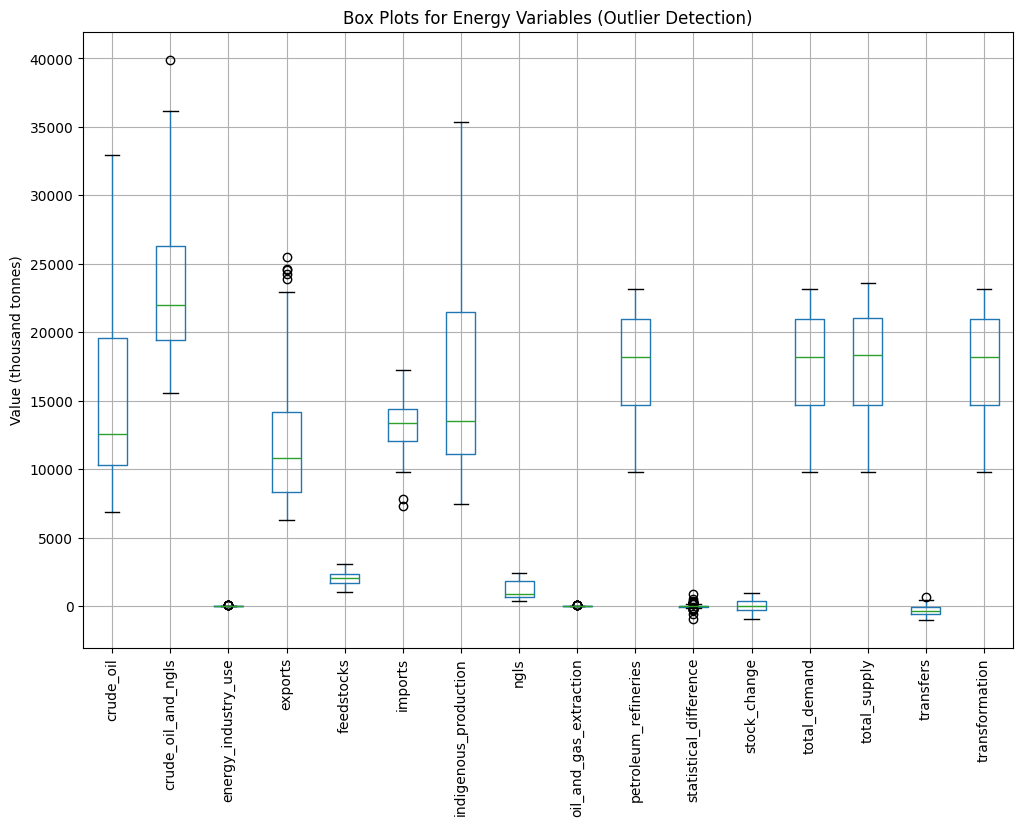


Regression Analysis: Indigenous Production over Time
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     470.3
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           8.66e-40
Time:                        09:07:34   Log-Likelihood:                -978.24
No. Observations:                 103   AIC:                             1960.
Df Residuals:                     101   BIC:                             1966.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [28]:
def main():
    response = requests.get(URL_PAGE)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'lxml')

    new_link = extract_link_from_jsonld(soup)
    last_link = load_last_link()
    
    if not new_link:
        raise Exception("Could not extract the spreadsheet link.")
    
    download_if_needed(new_link, last_link)
    
    clean_and_restructure(DOWNLOADED_EXCEL_FILE, new_link)

    perform_energy_eda()

if __name__ == "__main__":
    main()

### Analysis Summary

#### Regression Analysis on Indigenous Production

- **Model Fit:**  
  - **R-squared = 0.823:** About 82.3% of the variation in indigenous production is explained by the passage of time. This indicates a strong overall fit.

- **Regression Coefficients:**  
  - **Intercept (const ≈ 28,890):** This is the estimated indigenous production at the start of our time series.
  - **Slope (time_index ≈ -234):** On average, indigenous production decreases by approximately 234 units each quarter. This negative trend is statistically significant (p < 0.0001), suggesting a clear downward trend over time.

- **Statistical Significance:**  
  - Both coefficients are highly significant, as indicated by large t-statistics (45.353 for the intercept, -21.686 for time_index) and p-values near zero.
  - The model’s overall significance is supported by an F-statistic of 470.3 (p ≈ 8.66e-40).

- **Diagnostic Checks:**  
  - **Durbin-Watson Statistic = 0.183:** This very low value indicates potential positive autocorrelation in the residuals, meaning that the model may not be capturing all time-related patterns.
  - **Omnibus and Jarque-Bera Tests:** While the Omnibus test (p = 0.005) suggests some deviation from normality, the Jarque-Bera test (p = 0.150) is less conclusive. Overall, the residuals show some departures from normality but not to a degree that invalidates the model.

#### ANOVA for Seasonal Differences

- **ANOVA Results:**  
  - **F-statistic = 0.37, p-value = 0.7738:** This indicates no statistically significant difference in indigenous production means across quarters.
  
- **Interpretation:**  
  - The lack of significant seasonal differences suggests that indigenous production does not vary predictably by quarter. For a trader, this means that seasonal fluctuations in production may not be a reliable signal on their own.

#### Implications

- The **downward trend** in indigenous production (reflected by the negative slope) could signal a tightening of supply in the market. Traders might need to consider this long-term trend when assessing market risk.
- Despite strong overall model performance, the **autocorrelation** indicated by the Durbin-Watson statistic suggests that further refinement (e.g., using time series models that account for autocorrelation) may enhance forecast accuracy.
- The **absence of seasonal variation** implies that quarterly changes in indigenous production are not significant. Trading strategies should therefore focus more on the underlying trend and other market factors rather than expecting predictable seasonal spikes.